# Lab 10: Exercise solutions

In [1]:
with open('../course/common.py') as fin:
    exec(fin.read())

In [2]:
with open('../course/matplotlibconf.py') as fin:
    exec(fin.read())

## Exercise 1

This is a long and complex exercise, that should give you an idea of a real world scenario. Feel free to look at the solution if you feel lost. Also, feel free to run this on a GPU.

First of all download and unpack the male/female pictures from [here](https://www.zerotodeeplearning.com/media/z2dl/45bzty/male_female.tgz) into a subfolder of the `../data` folder. These images and labels were obtained from [Crowdflower](https://www.figure-eight.com/data-for-everyone/).

Your goal is to build an image classifier that will recognize the gender of a person from pictures.

- Have a look at the directory structure and inspect a couple of pictures
- Design a model that will take a color image of size 64x64 as input and return a binary output (female=0/male=1)
- Feel free to introduce any regularization technique in your model (Dropout, Batch Normalization, Weight Regularization)
- Compile your model with an optimizer of your choice
- Using `ImageDataGenerator`, define a train generator that will augment your images with some geometric transformations. Feel free to choose the parameters that make sense to you.
- Define also a test generator, whose only purpose is to rescale the pixels by 1./255
- use the function `flow_from_directory` to generate batches from the train and test folders. Make sure you set the `target_size` to 64x64.
- Use the `model.fit_generator` function to fit the model on the batches generated from the `ImageDataGenerator`. Since you are streaming and augmenting the data in real-time, you will have to decide how many batches make an epoch and how many epochs you want to run
- Train your model (you should get to at least 85% accuracy)
- Once you are satisfied with your training, check a few of the misclassified pictures.
- Read about [human bias in Machine Learning datasets](https://www.technologyreview.com/s/608986/forget-killer-robotsbias-is-the-real-ai-danger/)

In [3]:
%%bash

if [ ! -d ../data/male_female ]; then
    A=https://www.zerotodeeplearning.com/
    B=media/z2dl/45bzty/
    C=male_female.tgz
    wget $A$B$C -O male_female.tgz
    tar -xzvf male_female.tgz --directory ../data/
    rm male_female.tgz
fi

In [4]:
data_path = '../data/male_female/'

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from itertools import islice
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [6]:
from tensorflow.python.client import device_lib

In [7]:
tf.compat.v1.disable_eager_execution()

In [8]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3),
                     input_shape=(64, 64, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [9]:
# gpus = K.tensorflow_backend._get_available_gpus()
gpus = ['gpu:0', 'gpu:1']

In [10]:
NGPU = len(gpus)

In [11]:
if NGPU <= 1:
    model = create_model()
    ncopies = 1  # for batch size
else:
    with tf.device("/cpu:0"):
        model = create_model()
    model = multi_gpu_model(model, gpus=NGPU)
    ncopies = NGPU

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 3)    0           conv2d_input[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64, 64, 3)    0           conv2d_input[0][0]               
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1)            352129      lambda[0][0]                     
                                                                 lambda_1[0][0]               

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
batch_size = 16

In [15]:
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range=10,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=1./255)

In [16]:
train = train_gen.flow_from_directory(
    data_path + '/train', target_size=(64, 64),
    batch_size=batch_size * ncopies,
    class_mode='binary')

test = test_gen.flow_from_directory(
    data_path + '/test', target_size=(64, 64),
    batch_size=batch_size * ncopies,
    class_mode='binary')

Found 11663 images belonging to 2 classes.
Found 2920 images belonging to 2 classes.


In [17]:
test.class_indices

{'0_female': 0, '1_male': 1}

In [18]:
label_to_class = {0: 'female', 1: 'male'}

In [19]:
model.fit_generator(train,
                    steps_per_epoch=600,
                    epochs=3);

Epoch 1/3
600/600 [==============================] - 73s 122ms/step - loss: 0.6188 - accuracy: 0.6932
Epoch 2/3
600/600 [==============================] - 70s 116ms/step - loss: 0.4667 - accuracy: 0.7716
Epoch 3/3
600/600 [==============================] - 70s 116ms/step - loss: 0.4251 - accuracy: 0.7945


In [20]:
model.evaluate_generator(test, steps=len(test))

[0.43203149298610893, 0.78424656]

In [21]:
X_test = []
y_test = []
for ts in islice(test, 50):
    X_test.append(ts[0])
    y_test.append(ts[1])

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [22]:
y_test

array([1., 1., 1., ..., 0., 1., 1.], dtype=float32)

In [23]:
y_pred = model.predict(X_test).ravel().round(0)
y_pred

array([1., 1., 1., ..., 0., 1., 1.], dtype=float32)

In [24]:
wrong_idx = np.argwhere(y_test != y_pred).ravel()
wrong_idx

array([   3,    4,   11,   13,   17,   25,   30,   34,   39,   42,   44,
         45,   47,   49,   50,   56,   64,   68,   69,   72,   78,   81,
         84,   86,   87,   89,   90,   91,   92,   93,  110,  118,  120,
        126,  136,  140,  143,  148,  159,  164,  167,  168,  172,  183,
        189,  191,  201,  202,  208,  215,  218,  219,  226,  232,  234,
        240,  248,  249,  252,  255,  272,  273,  284,  290,  291,  301,
        303,  309,  315,  317,  322,  326,  335,  341,  343,  352,  354,
        355,  366,  368,  376,  394,  395,  396,  398,  399,  400,  406,
        410,  418,  421,  422,  431,  438,  439,  441,  442,  443,  448,
        450,  453,  456,  479,  484,  487,  495,  496,  502,  514,  518,
        519,  522,  525,  529,  530,  534,  542,  543,  545,  546,  548,
        549,  555,  556,  558,  565,  591,  593,  595,  596,  608,  610,
        611,  614,  632,  634,  650,  653,  654,  658,  659,  661,  662,
        663,  670,  672,  673,  678,  683,  684,  6

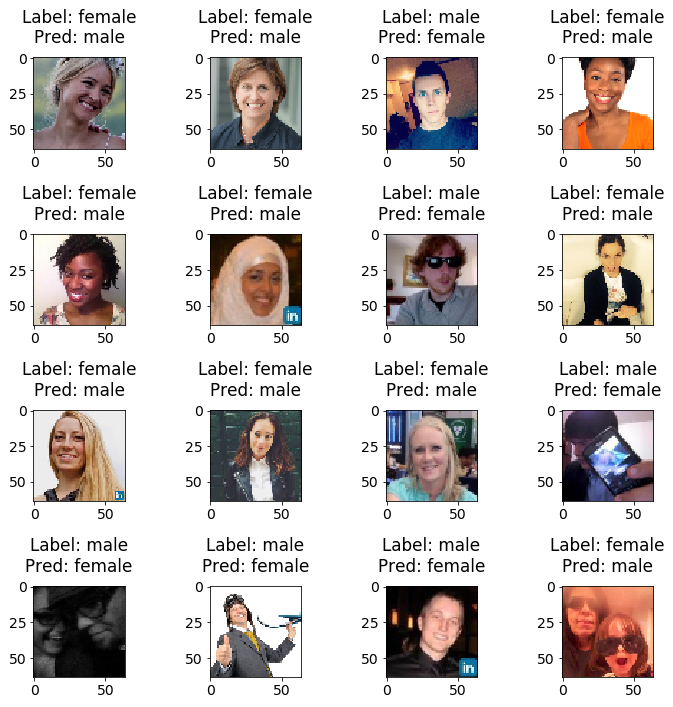

In [25]:
plt.figure(figsize=(10, 10))

i = 1

for idx in wrong_idx[:16]:
    plt.subplot(4, 4, i)
    plt.imshow(X_test[idx])
    label = label_to_class[int(y_test[idx])]
    pred = label_to_class[int(y_pred[idx])]
    plt.title("Label: {}\nPred: {}".format(label, pred))
    i += 1

plt.tight_layout()

The model still has a lot to learn about humans